# Finite-element mode solver

You can mesh any component cross-section and solve the PDEs thanks to [femwell](https://helgegehring.github.io/femwell/intro.html) mode - solver.

Unlike other mode solvers, this actually uses the component geometry instead of a hardcoded geometry.

You can directly compute the modes of a Gdsfactory cross-section (internally, it defines a "uz" mesh  perpendicular to a straight component with the provided cross-section).

You can also downsample layers from the LayerStack, and modify both the cross-section and LayerStack  prior to simulation to change the geometry. You can also define refractive indices on the active PDK.

In [1]:
import matplotlib.pyplot as plt
import gdsfactory as gf
from tqdm.auto import tqdm
import numpy as np
from femwell import mode_solver
from gdsfactory.simulation.fem.mode_solver import compute_cross_section_modes
from gdsfactory.technology import LayerStack
from gdsfactory.cross_section import rib
from gdsfactory.generic_tech import LAYER_STACK

import sys
import logging
from rich.logging import RichHandler

logger = logging.getLogger()
logger.removeHandler(sys.stderr)
logging.basicConfig(level="WARNING", datefmt="[%X]", handlers=[RichHandler()])

2023-01-22 16:14:01.411 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:14:02.321 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.


In [2]:
filtered_layerstack = LayerStack(
    layers={
        k: LAYER_STACK.layers[k]
        for k in (
            "core",
            "clad",
            "slab90",
            "box",
        )
    }
)

filtered_layerstack.layers[
    "core"
].thickness = 0.2  # Perturb the layerstack before simulating

resolutions = {}
resolutions["core"] = {"resolution": 0.02, "distance": 2}
resolutions["clad"] = {"resolution": 0.2, "distance": 1}
resolutions["box"] = {"resolution": 0.2, "distance": 1}
resolutions["slab90"] = {"resolution": 0.05, "distance": 1}

lams, basis, xs = compute_cross_section_modes(
    cross_section=rib(width=0.6),
    layerstack=filtered_layerstack,
    wl=1.55,
    num_modes=4,
    resolutions=resolutions,
)

[16:14:04] WARNING  WARNING:rich:This version of Tidy3D was pip installed from the 'tidy3d-beta'    ]8;id=331750;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=808400;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#102\102]8;;\
                    repository on PyPI. Future releases will be uploaded to the 'tidy3d'                           
                    repository. From now on, please use 'pip install tidy3d' instead.                              

           INFO     INFO:rich:Using client version: 1.8.2                                           ]8;id=667093;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py\__init__.py]8;;\:]8;id=422269;file:///usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d/__init__.py#120\120]8;;\

2023-01-22 16:14:05.077 | INFO     | gdsfactory.simulation.gtidy3d:<module>:54 - Tidy3d '1.8.2' installed at ['/usr/share/miniconda/envs/anaconda-client-env/lib/python3.9/site-packages/tidy3d']


2023-01-22 16:14:14.935 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_f44aaf43_ce353fd2.npz')


The solver returns the effective indices (lams), FEM basis functions (basis) and eigenvectors (xs):

In [3]:
lams, basis, xs

(array([2.56562633+6.77055620e-08j, 2.14074777-1.99106750e-08j,
        2.08164299-2.23166927e-08j, 2.0754274 -7.98847203e-10j]),
 <skfem CellBasis(MeshTri1, ElementComposite) object>
   Number of elements: 13730
   Number of DOFs: 27627
   Size: 63267840 B,
 array([[ 5.87958928e+00-5.48398693e+00j,  1.00176085e+01-9.34358314e+00j,
          7.92943764e+00-7.39591262e+00j, ...,
         -9.93136429e-09-4.82975225e-09j,  3.67504160e-05+3.94189196e-05j,
         -1.54699397e-06-1.89695101e-06j],
        [ 1.23095788e+00+4.94556327e+00j,  1.75546632e+00+7.05285473e+00j,
          1.09934268e+00+4.41677740e+00j, ...,
          2.65020364e-05-6.60348783e-06j, -9.43490780e-03+2.34836167e-03j,
          1.85659520e-02-4.62120448e-03j],
        [-1.55165836e+00-3.49388350e-01j, -1.62920741e+00-3.66849820e-01j,
         -9.97380877e-01-2.24581153e-01j, ...,
          2.01237406e-04-8.93703154e-04j, -7.79401487e-03+3.46136962e-02j,
          6.63530763e-02-2.94678705e-01j],
        [-1.11655637e

You can use them as inputs to other [femwell mode solver functions](https://github.com/HelgeGehring/femwell/blob/main/femwell/mode_solver.py) to inspect or analyze the modes:

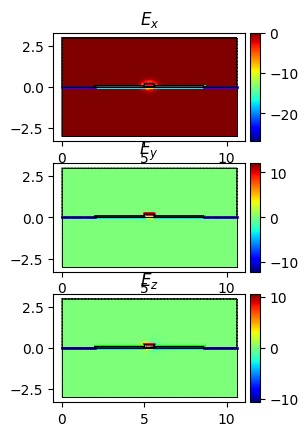

In [4]:
fig = mode_solver.plot_mode(
    basis, np.real(xs[0]), plot_vectors=False, colorbar=True, title="E", direction="y"
)

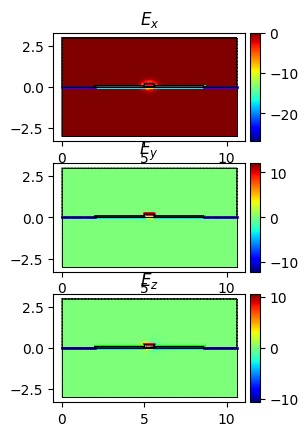

In [5]:
fig[0]

In [6]:
te_frac = mode_solver.calculate_te_frac(basis, xs[0])
te_frac

0.9905384201024471

## Sweep waveguide width

In [7]:
widths = np.linspace(0.2, 2, 20)
num_modes = 4
all_lams = np.zeros((widths.shape[0], num_modes))
all_te_fracs = np.zeros((widths.shape[0], num_modes))

for i, width in enumerate(tqdm(widths)):
    lams, basis, xs = compute_cross_section_modes(
        cross_section=gf.cross_section.strip(width=width),
        layerstack=filtered_layerstack,
        wl=1.55,
        num_modes=num_modes,
        resolutions=resolutions,
        wafer_padding=2,
    )
    all_lams[i] = lams
    all_te_fracs[i, :] = [
        mode_solver.calculate_te_frac(basis, xs[idx]) for idx in range(num_modes)
    ]

  0%|          | 0/20 [00:00<?, ?it/s]

2023-01-22 16:14:23.588 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_3e9a21bd_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:14:30.309 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_2f6d91a7_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:14:37.314 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_b76557f8_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:14:43.954 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_c5f4b290_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:14:53.336 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_09241e1d_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:14:59.868 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_7fe4b240_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:06.726 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_2d86ac00_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:11.784 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_ba346291_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:16.354 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_8528ff66_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:21.006 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_3cf0c077_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:25.716 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_b62973df_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:30.687 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_729092c5_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:36.495 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_d4922581_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:42.493 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_f2ba986f_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:48.391 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_e0cc9d0a_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:15:54.576 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_4839c75b_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:16:01.421 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_467af3b0_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:16:08.696 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_e0aa3c71_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:16:16.342 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_57f480b5_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


2023-01-22 16:16:23.934 | INFO     | gdsfactory.simulation.fem.mode_solver:compute_cross_section_modes:160 - Write mode to PosixPath('/home/runner/.gdsfactory/modes/xs_a6d85b35_efe87381.npz')


/tmp/ipykernel_10157/656326063.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  all_lams[i] = lams


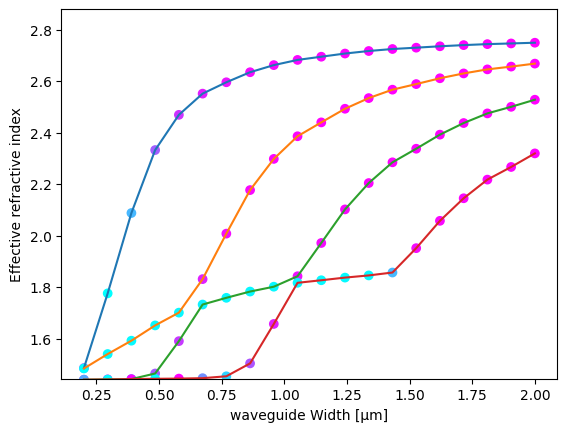

In [8]:
all_lams = np.real(all_lams)
plt.xlabel("waveguide Width [µm]")
plt.ylabel("Effective refractive index")
plt.ylim(1.444, np.max(all_lams) + 0.1 * (np.max(all_lams) - 1.444))

for lams, te_fracs in zip(all_lams.T, all_te_fracs.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")